# COVID-19 Prediction using Different models

In this project, I will use data from the last three months to predict confirmed cases and deaths for the month of April. The work has just begun, good results have been obtained. Much work remains to be done, for exampl: 

* to explore new functions
* try other models
* adjust their parameters

I will post all updates here. I ask you to support the project like if it seemed useful to you.

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import cycle, islice
import seaborn as sb
import matplotlib.dates as dates
import datetime as dt
from sklearn import preprocessing
from lale.lib.lale import NoOp
import lale
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
import plotly.graph_objects as go
import plotly_express as px
from sklearn.preprocessing import OrdinalEncoder

In [0]:
train = pd.read_csv("/kaggle/input/covid19-global-forecasting-week-3/train.csv")
test = pd.read_csv("/kaggle/input/covid19-global-forecasting-week-3/test.csv")
train.head()

,Id,Province_State,Country_Region,Date,ConfirmedCases,Fatalities
0,1,NaN,Afghanistan,2020-01-22,0.0,0.0
1,2,NaN,Afghanistan,2020-01-23,0.0,0.0
2,3,NaN,Afghanistan,2020-01-24,0.0,0.0
3,4,NaN,Afghanistan,2020-01-25,0.0,0.0
4,5,NaN,Afghanistan,2020-01-26,0.0,0.0


In [0]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23256 entries, 0 to 23255
Data columns (total 6 columns):
Id                23256 non-null int64
Province_State    9880 non-null object
Country_Region    23256 non-null object
Date              23256 non-null object
ConfirmedCases    23256 non-null float64
Fatalities        23256 non-null float64
dtypes: float64(2), int64(1), object(3)
memory usage: 1.1+ MB


Currenty, the date is coming as a string. Lets convert it into datetime format so that EDA on the data becomes easier.

In [0]:
train['Date'] = pd.to_datetime(train['Date'], format = '%Y-%m-%d')
test['Date'] = pd.to_datetime(test['Date'], format = '%Y-%m-%d')

# Exploratory Data Analysis

In [0]:
curr_date = train['Date'].max()
world_cum_confirmed = sum(train[train['Date'] == curr_date].ConfirmedCases)
world_cum_fatal = sum(train[train['Date'] == curr_date].Fatalities)
print('Number of Countires: ', len(train['Country_Region'].unique()))
print('End date in train dset: ', curr_date)
print('Number of confirmed cases: ', world_cum_confirmed)
print('Number of fatal cases: ', world_cum_fatal)

Number of Countires:  180
End date in train dset:  2020-04-06 00:00:00
Number of confirmed cases:  1344856.0
Number of fatal cases:  74560.0


In [0]:
train[['ConfirmedCases', 'Fatalities']].describe()

,ConfirmedCases,Fatalities
count,23256.000000,23256.000000
mean,750.543946,34.440746
std,6008.725072,438.508692
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,67.000000,0.000000
max,136675.000000,16523.000000


In [0]:
top_country_c = train[train['Date'] == curr_date].groupby(['Date','Country_Region']).sum().sort_values(['ConfirmedCases'], ascending=False)
top_country_c.head(10)

Id  ConfirmedCases  Fatalities
Date       Country_Region                                     
2020-04-06 US              1497717        366454.0     10779.0
           Spain             23295        136675.0     13341.0
           Italy             15591        132547.0     16523.0
           Germany           13558        103374.0      1810.0
           France           126485         98962.0      8926.0
           China            249678         82665.0      3335.0
           Iran              15163         60500.0      3739.0
           United Kingdom   314805         52277.0      5385.0
           Turkey            24793         30217.0       649.0
           Switzerland       23830         21657.0       765.0

*If you want to escape from panic and just take up the competition, you can safely go to these countries))*

In [0]:
top_country_c.tail()

Id  ConfirmedCases  Fatalities
Date       Country_Region                                     
2020-04-06 Bhutan             2858             5.0         0.0
           Gambia            13344             4.0         1.0
           Burundi            3821             3.0         0.0
           Papua New Guinea  20727             2.0         0.0
           Timor-Leste       24365             1.0         0.0

In [0]:
top_country_f = train[train['Date'] == curr_date].groupby(['Date','Country_Region']).sum().sort_values(['Fatalities'], ascending=False)
top_country_f.head(10)

Id  ConfirmedCases  Fatalities
Date       Country_Region                                     
2020-04-06 Italy             15591        132547.0     16523.0
           Spain             23295        136675.0     13341.0
           US              1497717        366454.0     10779.0
           France           126485         98962.0      8926.0
           United Kingdom   314805         52277.0      5385.0
           Iran              15163         60500.0      3739.0
           China            249678         82665.0      3335.0
           Netherlands       77986         18924.0      1874.0
           Germany           13558        103374.0      1810.0
           Belgium            2537         20814.0      1632.0

Confirmed Cases and Fatalities are cummulative sums of all the previous days. 

I added new features but haven’t used them yet. They look quite logical and useful (show the dynamics of the spread of the disease every day), I hope that come in handy later.

In [0]:
pr_confirm = train['ConfirmedCases'].value_counts(normalize=True)
pr_fatal = train['Fatalities'].value_counts(normalize=True)

print(f'Percs of confirmed case = {pr_confirm[1:].sum()*100}%')
print(f'Percs of fatality = {pr_fatal[1:].sum()*100}%')

Percs of confirmed case = 48.55091159270725%
Percs of fatality = 23.78310973512212%


In [0]:
def Country_cases(df, ConfirmedCases,*argv):
    f, ax=plt.subplots(figsize=(16,5))
    labels=argv
    for a in argv: 
        country=df.loc[(df['Country_Region']==a)]
        plt.plot(country['Date'],country['ConfirmedCases'],linewidth=3)
        plt.xticks(rotation=40)
        plt.legend(labels)
        ax.set(title='Evolution of the number of cases' )
        
def Country_fatalities(df, Fatalities,*argv):
    f, ax=plt.subplots(figsize=(16,5))
    labels=argv
    for a in argv: 
        country=df.loc[(df['Country_Region']==a)]
        plt.plot(country['Date'],country['Fatalities'],linewidth=3)
        plt.xticks(rotation=40)
        plt.legend(labels)
        ax.set(title='Evolution of the number of fatalities' )

/opt/conda/lib/python3.6/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning:

Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()



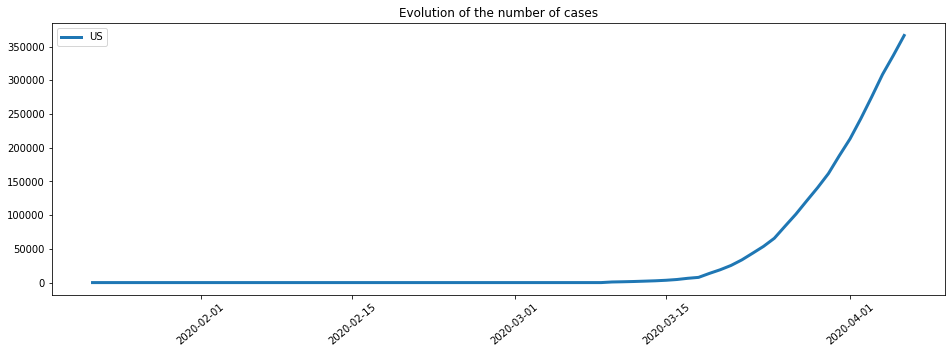

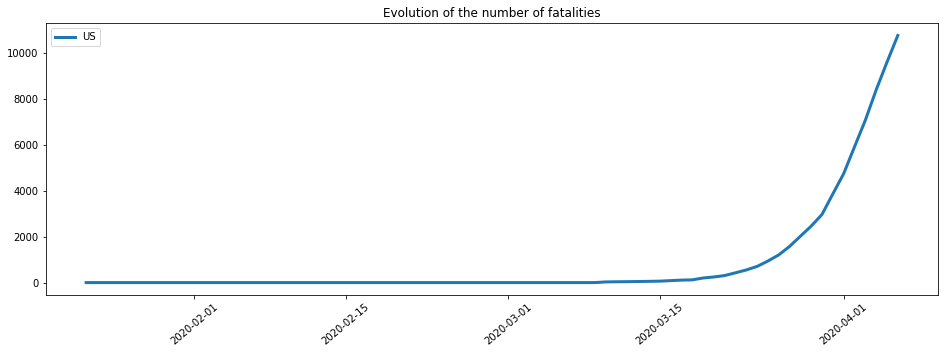

In [0]:
train_sum=train.groupby(['Date','Country_Region']).agg('sum').reset_index()

Country_cases(train_sum,'ConfirmedCases','US')
Country_fatalities(train_sum,'Fatalities','US')

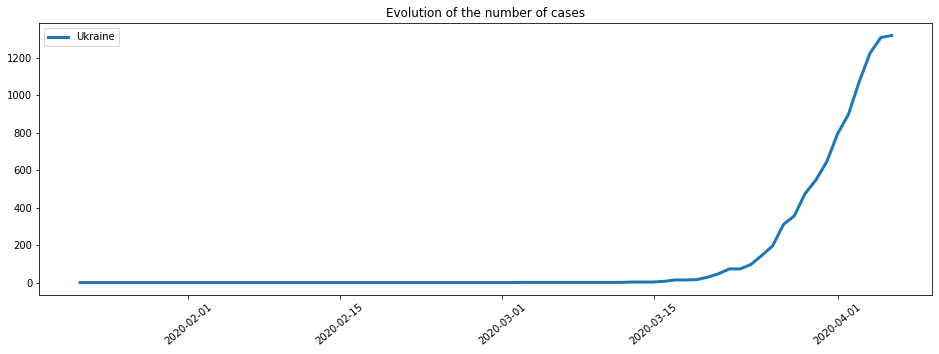

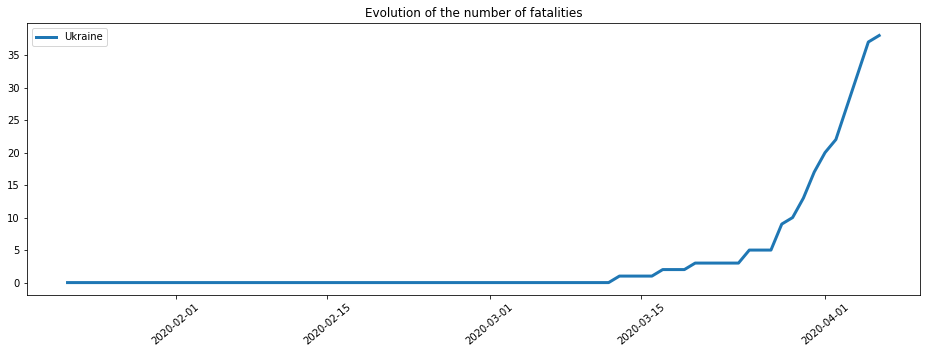

In [0]:
Country_cases(train_sum,'ConfirmedCases','Ukraine')
Country_fatalities(train_sum,'Fatalities','Ukraine')

In [0]:
case='ConfirmedCases'
def timeCompare(df, time,*argv):
    Coun1=argv[0]
    Coun2=argv[1]
    f,ax=plt.subplots(figsize=(16,5))
    labels=argv  
    country=df.loc[(df['Country_Region']==Coun1)]
    plt.plot(country['Date'],country[case],linewidth=2)
    plt.xticks([])
    plt.legend(labels)
    ax.set(title=' Evolution of actual cases',ylabel='Number of cases' )

    country2=df.loc[df['Country_Region']==Coun2]
    #country2['Date']=country2['Date']-datetime.timedelta(days=time)
    plt.plot(country2['Date'],country2[case],linewidth=2)
    #plt.xticks([])
    plt.legend(labels)
    ax.set(title=' Evolution of cases in %d days difference '%time ,ylabel='Number of %s cases'%case )

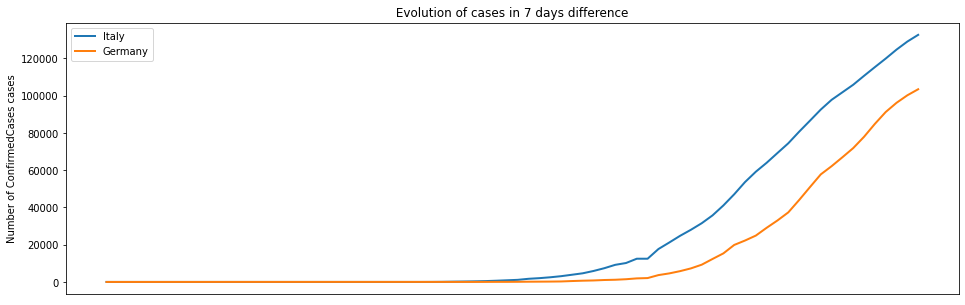

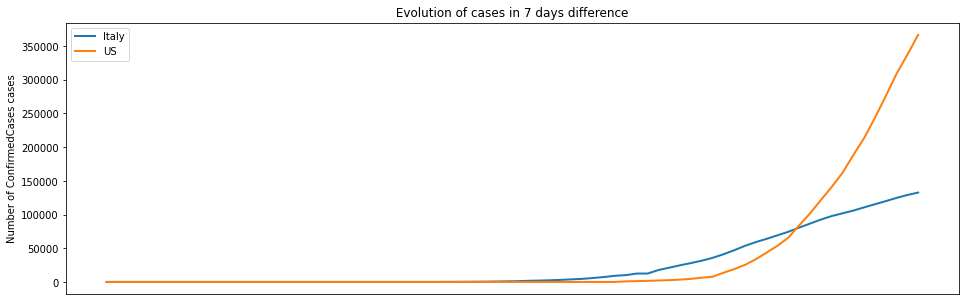

In [0]:
timeCompare(train_sum, 7,'Italy','Germany')
timeCompare(train_sum, 7,'Italy','US')

In [0]:
case='Fatalities'
def timeCompare_f(df, time,*argv):
    Coun1=argv[0]
    Coun2=argv[1]
    f,ax=plt.subplots(figsize=(16,5))
    labels=argv  
    country=df.loc[(df['Country_Region']==Coun1)]
    plt.plot(country['Date'],country[case],linewidth=2)
    plt.xticks([])
    plt.legend(labels)
    ax.set(title=' Evolution of actual cases',ylabel='Number of cases' )

    country2=df.loc[df['Country_Region']==Coun2]
    #country2['Date']=country2['Date']-datetime.timedelta(days=time)
    plt.plot(country2['Date'],country2[case],linewidth=2)
    #plt.xticks([])
    plt.legend(labels)
    ax.set(title=' Evolution of Fatalities in %d days difference '%time ,ylabel='Number of %s cases'%case )

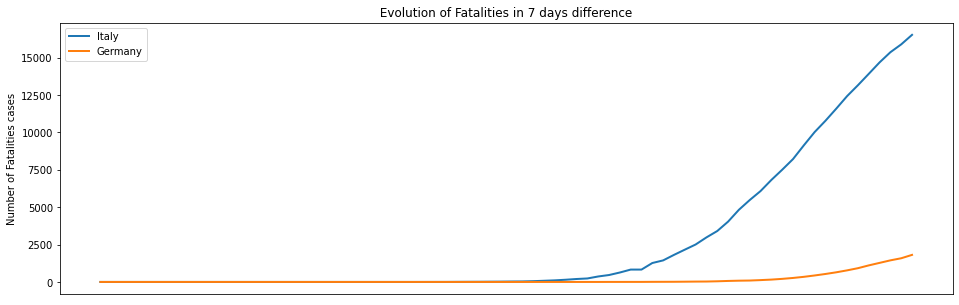

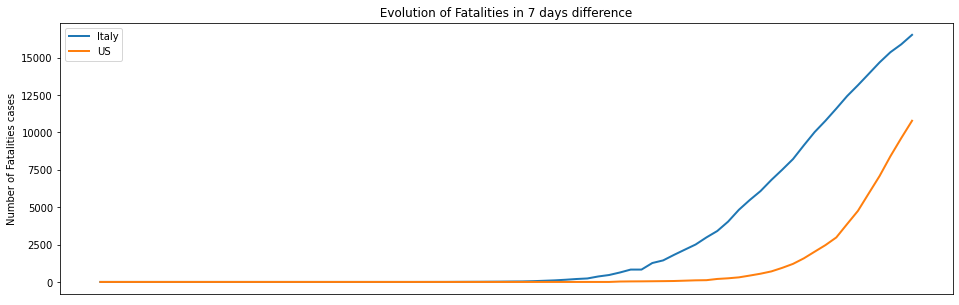

In [0]:
timeCompare_f(train_sum, 7,'Italy','Germany')
timeCompare_f(train_sum, 7,'Italy','US')

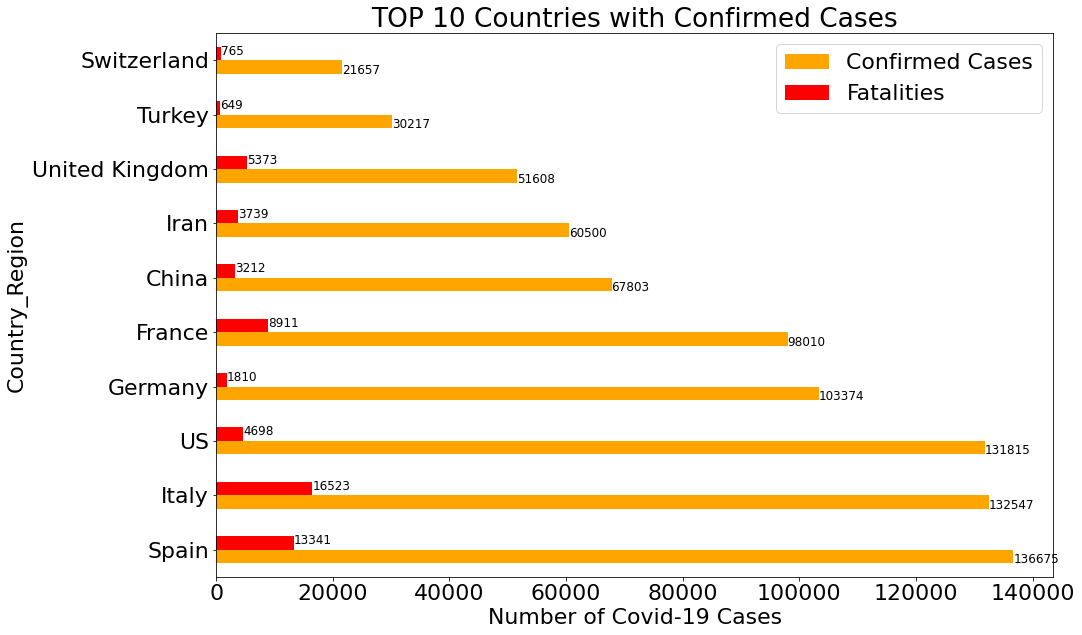

In [0]:
train_data_by_country = train.groupby(['Country_Region'],as_index=True).agg({'ConfirmedCases': 'max', 'Fatalities': 'max'})
train_data_by_country_confirm = train_data_by_country.sort_values(by=["ConfirmedCases"], ascending=False)

from itertools import cycle, islice

discrete_col = list(islice(cycle(['orange', 'r', 'g', 'k', 'b', 'c', 'm']), None, len(train_data_by_country_confirm.head(10))))
plt.rcParams.update({'font.size': 22})
train_data_by_country_confirm.head(10).plot(figsize=(15,10), kind='barh', color=discrete_col)
plt.legend(["Confirmed Cases", "Fatalities"]);
plt.xlabel("Number of Covid-19 Cases")
plt.title("TOP 10 Countries with Confirmed Cases")
ylocs, ylabs = plt.yticks()
for i, v in enumerate(train_data_by_country_confirm.head(10)["ConfirmedCases"][:]):
    plt.text(v+0.01, ylocs[i]-0.25, str(int(v)), fontsize=12)
for i, v in enumerate(train_data_by_country_confirm.head(10)["Fatalities"][:]):
    if v > 200: #disply for only >200 fatalities
        plt.text(v+0.01,ylocs[i]+0.1,str(int(v)),fontsize=12) 

From the interesting on this graph, we can distinguish a strangely high mortality rate in France compared with other countries with a similar incidence rate.
*Perhaps this is due to the level of medicine or some other factors.*

As well as a lower mortality rate in the USA than in the TOP 2 countries. I think this is due to the fact that they began to do mass testing of people there and to identify patients in the early stages.

In [0]:
train['MortalityRate'] = train['Fatalities'] / train['ConfirmedCases']
train['MortalityRate'] = train['MortalityRate'].fillna(0.0)

Confirmed Cases and Fatalities are cummulative sums of all the previous days. In order to understand the daily trend, I'll create a column for daily cases and deaths that will be the difference between the current value and the previous day's value

In [0]:
def add_daily_measures(df):
    df.loc[0,'Daily Cases'] = df.loc[0,'ConfirmedCases']
    df.loc[0,'Daily Deaths'] = df.loc[0,'Fatalities']
    for i in range(1,len(df)):
        df.loc[i,'Daily Cases'] = df.loc[i,'ConfirmedCases'] - df.loc[i-1,'ConfirmedCases']
        df.loc[i,'Daily Deaths'] = df.loc[i,'Fatalities'] - df.loc[i-1,'Fatalities']
    #Make the first row as 0 because we don't know the previous value
    df.loc[0,'Daily Cases'] = 0
    df.loc[0,'Daily Deaths'] = 0
    return df

df_world = train.copy()
df_world = df_world.groupby('Date',as_index=False)['ConfirmedCases','Fatalities'].sum()
df_world = add_daily_measures(df_world)

In [0]:
fig = go.Figure(data=[
    go.Bar(name='Cases', x=df_world['Date'], y=df_world['Daily Cases']),
    go.Bar(name='Deaths', x=df_world['Date'], y=df_world['Daily Deaths'])
])
# Change the bar mode
fig.update_layout(barmode='overlay', title='Worldwide daily Case and Death count')
fig.show()

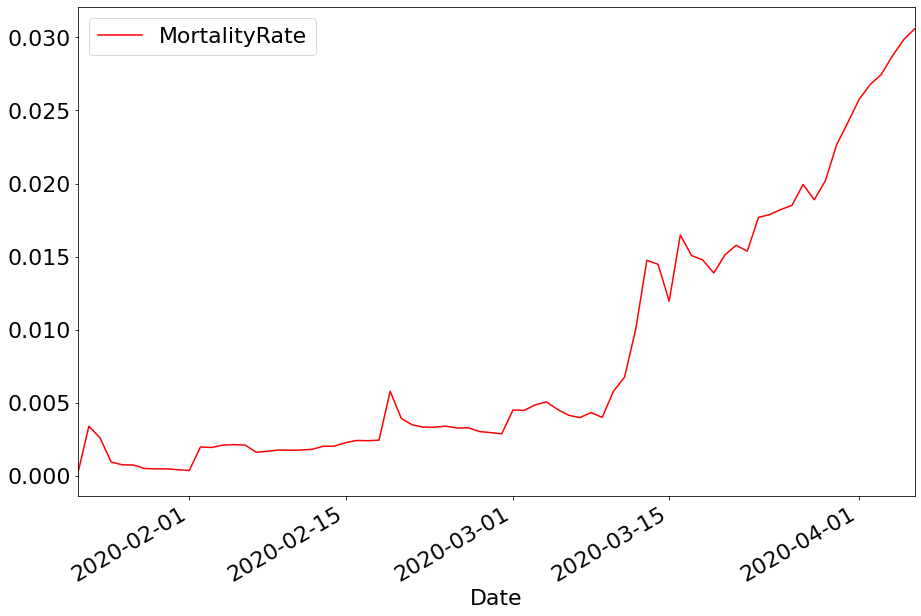

In [0]:
mort = train.copy()
mort['Date'] = pd.to_datetime(mort['Date'])
train_data_by_date = mort.groupby(['Date'],as_index=True).agg({'ConfirmedCases': 'sum','Fatalities': 'sum', 'MortalityRate':'mean'})

train_data_by_date.MortalityRate.plot(figsize=(15,10),x_compat=True, legend='Mortality Rate',color='r')

In [0]:
top_country_m = train[train['Date'] == curr_date].groupby(['Country_Region']).sum().sort_values(['MortalityRate'], ascending=False)
top_country_m.head(10)

,Id,ConfirmedCases,Fatalities,MortalityRate
Country_Region,,,,
US,1497717,366454.0,10779.0,1.326717
China,249678,82665.0,3335.0,0.364765
Netherlands,77986,18924.0,1874.0,0.338378
United Kingdom,314805,52277.0,5385.0,0.334901
Gambia,13344,4.0,1.0,0.250000
France,126485,98962.0,8926.0,0.245367
MS Zaandam,17517,9.0,2.0,0.222222
Liberia,16982,14.0,3.0,0.214286
Bahamas,2002,29.0,5.0,0.172414


Text(0.5, 1.0, 'First 10 Countries with Highest Mortality Rate')

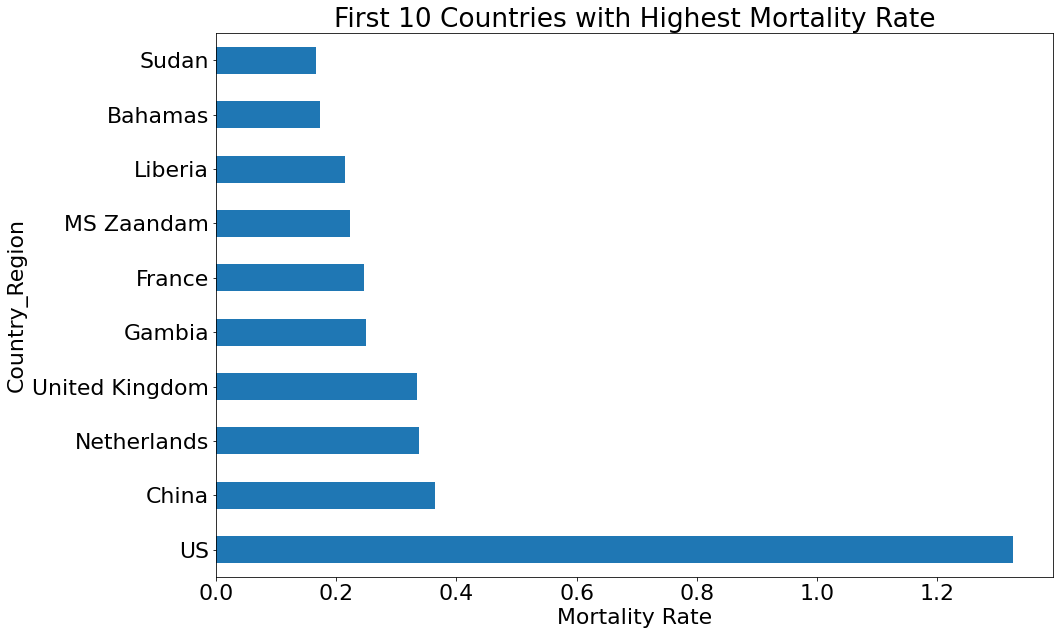

In [0]:
top_country_m.MortalityRate.head(10).plot(figsize=(15,10),kind='barh')
plt.xlabel("Mortality Rate")
plt.title("First 10 Countries with Highest Mortality Rate")


# Preprocessing

In [0]:
def create_features(df):
    df['day'] = df['Date'].dt.day
    df['month'] = df['Date'].dt.month
    df['dayofweek'] = df['Date'].dt.dayofweek
    df['dayofyear'] = df['Date'].dt.dayofyear
    df['quarter'] = df['Date'].dt.quarter
    df['weekofyear'] = df['Date'].dt.weekofyear
    return df

In [0]:
def train_dev_split(df, days):
    #Last days data as dev set
    date = df['Date'].max() - dt.timedelta(days=days)
    return df[df['Date'] <= date], df[df['Date'] > date]

Province_State contains null values. I will convert the null values to the string "NaN". And just below I replace the missing values with the name of the country. I think that the analysis and prediction of growth dynamics, provinces are not particularly important. They are needed already for a more detailed study of each country.

In [0]:
def categoricalToInteger(df):
    #convert NaN Province State values to a string
    df.Province_State.fillna('NaN', inplace=True)
    #Define Ordinal Encoder Model
    oe = OrdinalEncoder()
    df[['Province_State','Country_Region']] = oe.fit_transform(df.loc[:,['Province_State','Country_Region']])
    return df

In [0]:
df_train = categoricalToInteger(train)
df_train.info()
df_train = create_features(df_train)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23256 entries, 0 to 23255
Data columns (total 7 columns):
Id                23256 non-null int64
Province_State    23256 non-null float64
Country_Region    23256 non-null float64
Date              23256 non-null datetime64[ns]
ConfirmedCases    23256 non-null float64
Fatalities        23256 non-null float64
MortalityRate     23256 non-null float64
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 1.2 MB


In [0]:
df_train, df_dev = train_dev_split(df_train,0)

columns = ['day','month','dayofweek','dayofyear','quarter','weekofyear','Province_State', 'Country_Region','ConfirmedCases','Fatalities']
df_train = df_train[columns]
df_dev = df_dev[columns]

In [0]:
df_test = categoricalToInteger(test)
df_test = create_features(test)
#Columns to select
columns = ['day','month','dayofweek','dayofyear','quarter','weekofyear','Province_State', 'Country_Region']

*Next new features are wrong. I will try to use this idea in the next version*

In [0]:
#train['NewConfirmedCases'] = train['ConfirmedCases'] - train['ConfirmedCases'].shift(1)
#train['NewConfirmedCases'] = train['NewConfirmedCases'].fillna(0.0)
#train['NewFatalities'] = train['Fatalities'] - train['Fatalities'].shift(1)
#train['NewFatalities'] = train['NewFatalities'].fillna(0.0)

#train

In [0]:
#df_train.loc[:,'Confirmed_log']  = np.log10(df_train.loc[:,'ConfirmedCases'] + 1)
#df_train.loc[:,'Fatalities_log'] = np.log10(df_train.loc[:,'Fatalities'] + 1)

# Modeling

I prepared several initial models. So far I used only Random Forest and XGB.

In [0]:
def RF():
    model = RandomForestRegressor(n_estimators = 100) 
    return model

def XGB():
    model = XGBRegressor(n_estimators=1300)
    return model

def LGBM():
    model = LGBMRegressor(iterations=2)
    return model

Since we need to predict the number of diseases and the number of deaths, we will use the model separately for each predictor.

*Perhaps for each there will be your parameters, I will study this question later.*

**UPD:** LGBM not good

In [0]:
submission = []
#Loop through all the unique countries
for country in df_train.Country_Region.unique():
    #Filter on the basis of country
    df_train1 = df_train[df_train["Country_Region"]==country]
    #Loop through all the States of the selected country
    for state in df_train1.Province_State.unique():
        #Filter on the basis of state
        df_train2 = df_train1[df_train1["Province_State"]==state]
        #Convert to numpy array for training
        train = df_train2.values
        #Separate the features and labels
        X_train, y_train = train[:,:-2], train[:,-2:]
        #model1 for predicting Confirmed Cases
        model1 = XGBRegressor(n_estimators=1100)
        model1.fit(X_train, y_train[:,0])
        #model2 for predicting Fatalities
        model2 = XGBRegressor(n_estimators=1100)
        model2.fit(X_train, y_train[:,1])
        #Get the test data for that particular country and state
        df_test1 = df_test[(df_test["Country_Region"]==country) & (df_test["Province_State"] == state)]
        #Store the ForecastId separately
        ForecastId = df_test1.ForecastId.values
        #Remove the unwanted columns
        df_test2 = df_test1[columns]
        #Get the predictions
        y_pred1 = np.round(model1.predict(df_test2.values),5)
        y_pred2 = np.round(model2.predict(df_test2.values),5)
        #Append the predicted values to submission list
        for i in range(len(y_pred1)):
            d = {'ForecastId':ForecastId[i], 'ConfirmedCases':y_pred1[i], 'Fatalities':y_pred2[i]}
            submission.append(d)

Convert the submission list to DataFrame and save it as csv for submission

In [0]:
df_submit = pd.DataFrame(submission)

df_submit.to_csv(r'submission.csv', index=False)